<a href="https://colab.research.google.com/github/GiulianoPepato/university-codes/blob/main/Atividade_2_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Giuliano Andrade Rodrigues Pepato

In [ ]:
!pip install ucimlrepo

from ucimlrepo import fetch_ucirepo

# fetch dataset
superconductivty_data = fetch_ucirepo(id=464)

# data (as pandas dataframes)
X = superconductivty_data.data.features
y = superconductivty_data.data.targets

# metadata
print(superconductivty_data.metadata)

# variable information
print(superconductivty_data.variables)

{'uci_id': 464, 'name': 'Superconductivty Data', 'repository_url': 'https://archive.ics.uci.edu/dataset/464/superconductivty+data', 'data_url': 'https://archive.ics.uci.edu/static/public/464/data.csv', 'abstract': 'Two file s contain data on 21263 superconductors and their relevant features.', 'area': 'Physics and Chemistry', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 21263, 'num_features': 81, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['critical_temp'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2018, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C53P47', 'creators': ['Kam Hamidieh'], 'intro_paper': {'ID': 452, 'type': 'NATIVE', 'title': 'A data-driven statistical model for predicting the critical temperature of a superconductor', 'authors': 'K. Hamidieh', 'venue': 'Computational materials science', 'year': 2018, 'journal': None, 'DOI': None, 'URL': 'http

Podemos notar que não há quais quer valores faltantes no nossa database, então não precisamos nos preocupar com isso.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

#1) Análise Exploratória

Vamos ver quais as *features* da nossa base de dados (database) e quantos dados há.

In [ ]:
print(f'O conjunto de atributos é {X.columns} e possui um total de {len(X)} entradas.')
print('')
print(f'y é o nosso atributo alvo {y.columns} e também possui {len(y)}')

O conjunto de atributos é Index(['number_of_elements', 'mean_atomic_mass', 'wtd_mean_atomic_mass',
       'gmean_atomic_mass', 'wtd_gmean_atomic_mass', 'entropy_atomic_mass',
       'wtd_entropy_atomic_mass', 'range_atomic_mass', 'wtd_range_atomic_mass',
       'std_atomic_mass', 'wtd_std_atomic_mass', 'mean_fie', 'wtd_mean_fie',
       'gmean_fie', 'wtd_gmean_fie', 'entropy_fie', 'wtd_entropy_fie',
       'range_fie', 'wtd_range_fie', 'std_fie', 'wtd_std_fie',
       'mean_atomic_radius', 'wtd_mean_atomic_radius', 'gmean_atomic_radius',
       'wtd_gmean_atomic_radius', 'entropy_atomic_radius',
       'wtd_entropy_atomic_radius', 'range_atomic_radius',
       'wtd_range_atomic_radius', 'std_atomic_radius', 'wtd_std_atomic_radius',
       'mean_Density', 'wtd_mean_Density', 'gmean_Density',
       'wtd_gmean_Density', 'entropy_Density', 'wtd_entropy_Density',
       'range_Density', 'wtd_range_Density', 'std_Density', 'wtd_std_Density',
       'mean_ElectronAffinity', 'wtd_mean_Electro

Podemos excluir a coluna de número de elementos

Podemos olhar os histogramas e bloxplot de cada uma das 81 *features* para analisar as dsitribuições e procurar *outliners*.

In [ ]:
num_cols = len(X.columns)
num_figures = (num_cols + 8) // 9  # Calculate the number of figures needed

for i in range(num_figures):
    plt.figure(figsize=(15, 15))
    for j in range(9):
        col_index = i * 9 + j
        if col_index < num_cols:
            plt.subplot(3, 3, j + 1)
            plt.hist(X.iloc[:, col_index], bins=50)
            plt.xlabel(X.columns[col_index])
            plt.ylabel('Frequency')
            plt.title(f'Histogram of {X.columns[col_index]}')
    plt.tight_layout()
    plt.show()

In [ ]:
for i in range(num_figures):
    plt.figure(figsize=(15, 15))
    for j in range(9):
        col_index = i * 9 + j
        if col_index < num_cols:
            plt.subplot(3, 3, j + 1)
            plt.boxplot(X.iloc[:, col_index])
            plt.xlabel(X.columns[col_index])
            plt.ylabel('Frequency')
            plt.title(f'Boxplot of {X.columns[col_index]}')
    plt.tight_layout()
    plt.show()

Nota-se que há algumas *features* que range de distribuições é bem diferente das demais e que há a presença de alguns outliners, porém de começo vamos seguir com a análise sem fazer qualquer remoção de dado. Também podemos dar uma olhada na correlação entre algumas features.

In [ ]:
X = X.drop(columns = 'number_of_elements')

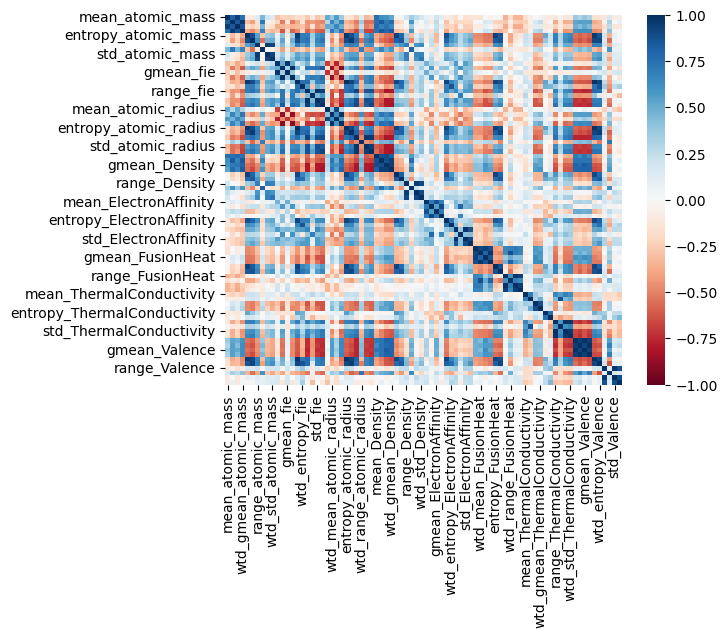

In [ ]:
matriz_corr = X.corr().round(2)
sns.heatmap(matriz_corr, cmap = 'RdBu', vmin=-1, vmax=1);

#2) Preparação dos dados: escalonamento, transformação, particionamento

Como notamos que algumas features possuem diferentes ranges, inclusive de ordens de grandeza, é neessário usar um escalonamento de *StandardScaler* para os nossos conjuntos de dados. Vale a atenção de dizer que devemos escalonar os conjuntos de teste e treinamento separadamente para que não haja vazamento de informações para o modelo.

In [ ]:
seed = 13687220

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = seed)

In [ ]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

Aqui podemos usar para a partição uma validação cruzada tipo *k-fold* para treinar o algoritmo com pequenos subconjuntos do conjunto de treinamento e validar com pequenos subconjuntos do conjunto de teste.

In [ ]:
from sklearn.model_selection import cross_val_score, KFold

# Define the number of folds
n_splits = 5  # foi definido apenas 5 folds porque o algoritmo estava demorando demais para terminar de rodar

# Initialize KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state = seed)

# 3) Avaliar a importância dos atributos com base nos coeficientes de um modelo de regressão linear múltipla (com ou sem regularização, à sua escolha).


In [ ]:
from sklearn import linear_model
regr = linear_model.LinearRegression() # Create regressor
regr.fit(X_train_s, y_train) # Train regressor

y_pred_train = regr.predict(X_train_s) # predição para o conjunto de treino
y_pred_test = regr.predict(X_test_s) # predição para o conjunto de teste

print('Intercepto:', regr.intercept_)
print('Coeficientes:', regr.coef_)
print('R^2 = ', regr.score(X_train_s, y_train)) # Coefficient of determination R^2

Intercepto: [34.55345932]
Coeficientes: [[  21.45783352  -26.64532981  -12.25423102   19.89516768  -11.26318147
     1.34366864   10.94437989    0.27997948   -9.32126325    0.97535126
    11.03234498  -22.58857898   -9.52973989   21.58477573  -41.48186309
    16.49859265   14.31468337    5.88273223  -16.79798518   -2.4934625
   -14.90703875   94.15692741    8.88909073 -103.29945909   21.89387469
    18.25928506   15.40076874   -2.99988467   -8.4477872    -9.0925216
   -12.11271909   -1.36443175    2.59476132   10.52264731    3.64909946
    -5.30478023   -6.9760538     0.16275242    9.48837757   -1.88352913
    -4.02553438   18.01835348    5.71041904  -18.30960288    1.08140497
    -6.03115859  -21.05631061   -4.76643821   27.45963819  -11.76221856
    18.22226407  -28.3669678   -15.06487279   22.66076821   -6.89345921
     9.17023307   -7.57947551    6.43282809   -3.96688882    5.49532003
    -3.57719682   25.91462314   -1.31969023  -15.23381792    4.21330371
     0.23327896  -19.53352

Como aqui temos muitos coeficientes, fica muito díficil fazer qualquer análise da importância de cada atributo. Em seguida usamos a validação cruzada para testar os diferentes subconjuntos.

In [ ]:
# Perform cross-validation
scores = cross_val_score(linear_model.LinearRegression(), X, y, cv=kf, scoring='r2')

print(f'Cross-validation R^2 scores for each fold: {scores}')
print(f'Mean Cross-validation R^2: {scores.mean()}')
print(f'Standard Deviation of Cross-validation R^2: {scores.std()}')

Cross-validation R^2 scores for each fold: [0.73472508 0.73822005 0.73975355 0.73146569 0.73056052]
Mean Cross-validation R^2: 0.7349449810455612
Standard Deviation of Cross-validation R^2: 0.0036118069079320103


# 4) Avaliar a importância dos atributos com base em um regressor Random Forest ou Gradient Boosting.


In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth= 15,random_state = seed)
rf.fit(X_train_s, y_train)
y_pred_train = rf.predict(X_train_s) # predição para o conjunto de treinamento
y_pred_test = rf.predict(X_test_s) # predição para o conjunto de teste

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print('Regressão Random Forest otimizado')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_train, y_pred_train))
print('MSE = ', mean_squared_error(y_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_test, y_pred_test))
print('MSE = ', mean_squared_error(y_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_test, y_pred_test))

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Regressão Random Forest otimizado
Desempenho no conjunto de treino
R^2 =  0.9717760112570684
MSE =  33.1911372638326
MAE =  3.308046050298503
Desempenho no conjunto de teste
R^2 =  0.9201027970594131
MSE =  93.23262836213841
MAE =  5.527200719077632


In [ ]:
scores = cross_val_score(RandomForestRegressor(max_depth = 50, random_state = seed), X, y, cv=kf, scoring='r2')

print(f'Cross-validation Accuracy scores for each fold: {scores}')
print(f'Mean Cross-validation Accuracy: {scores.mean()}')
print(f'Standard Deviation of Cross-validation Accuracy: {scores.std()}')

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Cross-validation Accuracy scores for each fold: [0.92035252 0.9284776  0.92501608 0.92360219 0.92153977]
Mean Cross-validation Accuracy: 0.9237976324690568
Standard Deviation of Cross-validation Accuracy: 0.002842241496318715


In [ ]:
importances = rf.feature_importances_

feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
}).sort_values('importance', ascending=False)

In [ ]:
display(feature_importance.head(20))

,feature,importance
66,range_ThermalConductivity,0.541872
63,wtd_gmean_ThermalConductivity,0.131452
38,std_Density,0.020446
73,wtd_gmean_Valence,0.019900
8,std_atomic_mass,0.014225
32,gmean_Density,0.011988
71,wtd_mean_Valence,0.011262
30,mean_Density,0.010659
65,wtd_entropy_ThermalConductivity,0.010261
69,wtd_std_ThermalConductivity,0.009905


Avaliando a métrica *feature_importance_* nos 10 maiores valores, pode se notar que as propriedades que ele considera mais importante são a thermal conductivity, density, valence e atomic mass, mas diferentes *features* para cada uma, ou seja, não é necessário usar todas as propriedades nem todos os atributos.

# 5) Com base nos resultados dos itens 3 e 4, selecionar os atributos mais importantes. O número de atributos fica à sua escolha. Justificar sua escolha. Discutir brevemente se os atributos escolhidos possuem significado físico, ou seja, se de fato pode existir uma relação com a variável alvo (temperatura crítica).

Pelo item 4), vou considerar usar apenas 4 propriedades que o *RandomForestRegressor* deu maior importância: *thermal conductivity*, *density*, *valence*, *first ionization energy* (fie), não usarei a massa atômica pois essa é muito correlacionada com a densidade. A condutividade térmica é a propriedade mais importante justamente porque mede a capacidade do material de conduzir calor e como supercondutores precisam estar em condições de baixas temperaturas, é muito importante que um material tenha baixissíma condutividade térmica. A segunda propriedade, a densidade, é muito importante pois é necessário que o material seja compacto para, talvez, facilitar o transito de corrente elétrica. A valencia, por sua vez, é importante pois os elétrons livres que formam a corrente elétrica justamente vem das últimas camadas dos elementos. Por fim, a primeira energia de ionização é importante pois não queremos materiais que percam elétrons deixando a corrente mais fraca.

Como o tem 3) não sugere que algum atributo seja muito mais importante que outro, vou assumir que que posso selecionar os atributos que julgo importante, embora me apoie no que o item 4) diz. No caso, as features serão *range_ThermalConductivity* (intervalos pequenos são mais confiaveis), *wtd_gmean_ThermalConductivity* (para ter uma estimativa como valor), *std_Density* (importante que as estimativas de densidade são sejam muito dispersas), *gmean_Density*  (também para ter uma estimativa como valor), *wtd_gmean_Valence* e *wtd_range_fie*

# 6) Aplicar uma técnica de redução de dimensionalidade, como PCA (análise de componentesprincipais), criando novos atributos a partir de uma combinação dos atributos originais. O número de componentes principais a serem utilizadas fica à sua escolha (justificar escolha)

Aplicando o método de PCA para calcular as componentes que explicam 90% da variância dos dados, tenho 12 novas componentes:

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)

        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.743386 -0.671760 -3.010733  1.770929  0.241249 -0.242314  0.428352   
1  4.521007  0.380771 -1.658844  1.144624  0.975353 -0.981376 -0.320455   
2  3.565665 -0.731439 -3.102370  1.875407  0.290381 -0.247928  0.468570   
3  3.659504 -0.698511 -3.052878  1.821137  0.265167 -0.246088  0.446728   
4  3.889817 -0.631144 -2.942587  1.679454  0.195817 -0.230389  0.399022   

        PC8       PC9      PC10      PC11      PC12  
0 -0.220680 -0.395996 -0.200789 -0.633409  0.158793  
1  0.221059  0.420853  1.139054 -1.067221  0.578264  
2  0.007895 -0.505631 -0.162414 -0.738792  0.150672  
3 -0.110198 -0.449640 -0.180938 -0.685175  0.155110  
4 -0.425540 -0.293521 -0.242890 -0.534094  0.164547  
Variância explicada por componente: [0.38470693 0.10528172 0.0958056  0.07977746 0.05954879 0.03821542
 0.03654055 0.03144611 0.02383874 0.01992272 0.01851102 0.01476253]
Variância total explicada: 0.908357600128169


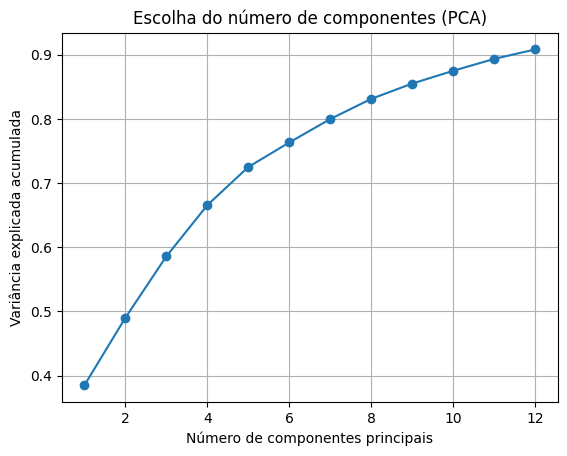

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ajuste o PCA e transforme os dados originais
X_pca = pca.fit_transform(X_scaled)

# Converta o resultado em um DataFrame
X_pca_df = pd.DataFrame(
    X_pca,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# Exiba os novos atributos
print(X_pca_df.head())

# (Opcional) Verifique a variância explicada por cada componente
print("Variância explicada por componente:", pca.explained_variance_ratio_)
print("Variância total explicada:", pca.explained_variance_ratio_.sum())

var_explicada = pca.explained_variance_ratio_

# Variância explicada acumulada
var_acumulada = np.cumsum(var_explicada)

plt.plot(range(1, len(var_acumulada)+1), var_acumulada, marker='o')
plt.xlabel('Número de componentes principais')
plt.ylabel('Variância explicada acumulada')
plt.title('Escolha do número de componentes (PCA)')
plt.grid(True)
plt.show()

# 7) Construir um modelo de regressão linear múltipla com:

## a) os atributos mais importantes, escolhidos no item 5

In [ ]:
atributos = ['range_ThermalConductivity', 'wtd_gmean_ThermalConductivity', 'std_Density',
             'gmean_Density', 'wtd_gmean_Valence', 'wtd_range_fie']

X_at = X[atributos]
display(X_at.head())

X_at_train, X_at_test, y_at_train, y_at_test = train_test_split(X_at, y, test_size=0.3, random_state = seed)

,range_ThermalConductivity,wtd_gmean_ThermalConductivity,std_Density,gmean_Density,wtd_gmean_Valence,wtd_range_fie
0,399.97342,0.621979,3306.162897,724.953211,2.219783,735.985714
1,429.97342,0.619735,3767.403176,1237.095080,2.210679,743.164286
2,399.97342,0.619095,3306.162897,724.953211,2.232679,743.164286
3,399.97342,0.620535,3306.162897,724.953211,2.226222,739.575000
4,399.97342,0.624878,3306.162897,724.953211,2.206963,728.807143


In [ ]:
scaler = StandardScaler()
scaler.fit(X_at_train)
X_at_train_s = scaler.transform(X_at_train)
X_at_test_s = scaler.transform(X_at_test)

regr = linear_model.LinearRegression() # Create regressor
regr.fit(X_at_train_s, y_at_train) # Train regressor

y_pred_train = regr.predict(X_at_train_s) # predição para o conjunto de treino
y_pred_test = regr.predict(X_at_test_s) # predição para o conjunto de teste

print('Intercepto:', regr.intercept_)
print('Coeficientes:', regr.coef_)
print('R^2 = ', regr.score(X_at_train_s, y_at_train)) # Coefficient of determination R^2

Intercepto: [34.55345932]
Coeficientes: [[18.12990791 -2.23467664  0.7475466  -2.13198916 -7.05458391 -4.08692961]]
R^2 =  0.5136870862889372


## b)  usando as componentes principais como atributos

In [ ]:
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(X_pca_df, y, test_size=0.2, random_state = seed)

scaler = StandardScaler()
scaler.fit(X_pca_train)
X_pca_train_s = scaler.transform(X_pca_train)
X_pca_test_s = scaler.transform(X_pca_test)

regr = linear_model.LinearRegression() # Create regressor
regr.fit(X_pca_train_s, y_pca_train) # Train regressor

y_pred_train = regr.predict(X_pca_train_s) # predição para o conjunto de treino
y_pred_test = regr.predict(X_pca_test_s) # predição para o conjunto de teste

print('Intercepto:', regr.intercept_)
print('Coeficientes:', regr.coef_)
print('R^2 = ', regr.score(X_pca_train_s, y_pca_train)) # Coefficient of determination R^2
print('R^2 = ', regr.score(X_pca_test_s, y_pca_test)) # Coefficient of determination R^2

Intercepto: [34.54846532]
Coeficientes: [[22.46041298  6.43264872 -6.16945582 -3.25517022  5.65402348  6.05966062
  -0.92413547 -0.84053848 -2.68410469 -0.09869327  3.87647179 -2.12038352]]
R^2 =  0.5862404161800421
R^2 =  0.5883788189787471


Podemos notar que nem para o conjunto delecionado, nem para os novos atributos do PCA a regressão linear múltipla deram bons ajustes para previsão. Alguns coeficientes dos dados do PCA tendem a ser correlacionados pois crescem em iguais magnetudes mas sinais opostos, enquanto que no conjunto de atributos selecionaos não tende a isso.

#8) Construir um modelo de regressão baseado em Random Forest ou Gradient Boosting com:

## a) apenas os atributos mais importantes, escolhidos no item 5

In [ ]:
rf = RandomForestRegressor(max_depth = 15, random_state = seed)
rf.fit(X_at_train_s, y_at_train)
y_pred_train = rf.predict(X_at_train_s) # predição para o conjunto de treinamento
y_pred_test = rf.predict(X_at_test_s) # predição para o conjunto de teste

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print('Regressão Random Forest otimizado')
print('')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_at_train, y_pred_train))
print('MSE = ', mean_squared_error(y_at_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_at_train, y_pred_train))
print('')
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_at_test, y_pred_test))
print('MSE = ', mean_squared_error(y_at_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_at_test, y_pred_test))

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Regressão Random Forest otimizado

Desempenho no conjunto de treino
R^2 =  0.9627872009608294
MSE =  43.76189106827979
MAE =  3.8727748645007414

Desempenho no conjunto de teste
R^2 =  0.900079736462543
MSE =  116.59768369065559
MAE =  6.232334136819391


## b) usando as componentes principais como atributos

In [ ]:
rf.fit(X_pca_train_s, y_pca_train)
y_pred_train = rf.predict(X_pca_train_s) # predição para o conjunto de treinamento
y_pred_test = rf.predict(X_pca_test_s) # predição para o conjunto de teste

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
print('Regressão Random Forest otimizado')
print('Desempenho no conjunto de treino')
print('R^2 = ', r2_score(y_pca_train, y_pred_train))
print('MSE = ', mean_squared_error(y_pca_train, y_pred_train))
print('MAE = ', mean_absolute_error(y_pca_train, y_pred_train))
print('Desempenho no conjunto de teste')
print('R^2 = ', r2_score(y_pca_test, y_pred_test))
print('MSE = ', mean_squared_error(y_pca_test, y_pred_test))
print('MAE = ', mean_absolute_error(y_pca_test, y_pred_test))

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Regressão Random Forest otimizado
Desempenho no conjunto de treino
R^2 =  0.9095581476083812
MSE =  106.37783917773805
MAE =  6.863592242673087
Desempenho no conjunto de teste
R^2 =  0.8689951897533678
MSE =  152.14932204502298
MAE =  7.947799253417375


Usando o RandomForestRegressor, tivemos um bom ajuste para os dados.

# 9) Fazer uma breve discussão crítica sobre o desempenho, a interpretabilidade e o custo computacional dos modelos lineares e dos modelos baseados em árvores de decisão.

Após toda a análise feita, podemos concluir que embora o modelo de regressão linear múltipla tenha um custo computacional mais baixo, o algoritmo de Random Forest Regressor apresenta um desempenho muito melhor.